In [1]:
import torch
from dataloader import get_train_and_validation_dataloader
import matplotlib.pyplot as plt
import numpy as np
from data_importer import load_training_images, load_testing_images, trunc, denormalize

In [2]:
import numpy as np
import scipy.signal

from skimage.metrics import structural_similarity as ssim
def compute_MSE(img1, img2):
    return np.mean(np.square(img1 - img2))

def compute_PSNR(img1, img2, data_range):
    mse_ = compute_MSE(img1, img2)
    return 10 * np.log10((data_range ** 2) / mse_)

def calculate_ssim(original_image, reconstructed_image):    
    ssim_value = ssim(original_image.astype(np.float32), reconstructed_image.astype(np.float32), win_size=7,  channel_axis=2, data_range=240+160)
    return ssim_value




In [3]:
def patch_extractor(image, patch_width=64, patch_height=64):
    image = image.copy()
    print(image.shape) 
    num_images, image_height, image_width, channels = image.shape
    patches = image.reshape(-1, image_height // patch_height, patch_height, image_width // patch_width, patch_width, channels)
    patches = patches.swapaxes(2, 3)
    patches = patches.reshape(-1, patch_height, patch_width, channels)
    
    return torch.from_numpy(patches)
 

In [4]:
# Common testing image pairs (used to evaluate all models)
training_dataloader, validation_dataloader = get_train_and_validation_dataloader(root_dataset_dir='../../../../../Dataset/LowDoseCTGrandChallenge/Training_Image_Data', shuffle=False)

number of image paths :  15152
number of image paths :  1472
Train and validation data image len : 15152, 1472


Code for evaluation of model(s)

In [5]:
def reconstruct_image_from_patches(patches, num_patches_per_row):
    print(patches.shape, ' shape before reconstructing image from patches')
    patch_size = patches.shape[1]  # Assuming square patches
    num_patches = patches.shape[0]

    # Calculate the number of rows
    num_patches_per_col = num_patches // num_patches_per_row

    # Initialize an empty image to store the reconstructed result
    reconstructed_image = np.zeros((num_patches_per_col * patch_size, num_patches_per_row * patch_size))

    # Reshape the patches into a 2D array
    patches_2d = patches.reshape((num_patches_per_col, num_patches_per_row, patch_size, patch_size))

    # Reconstruct the image by placing each patch in its corresponding position
    for i in range(num_patches_per_col):
        for j in range(num_patches_per_row):
            reconstructed_image[i * patch_size:(i + 1) * patch_size, j * patch_size:(j + 1) * patch_size] = patches_2d[i, j]

    return np.expand_dims(reconstructed_image, axis=-1)



In [6]:
def visualize_patches(patches, noisy_images,  ground_truth_images, num_images):
    num_patches_per_image = patches.shape[0] // num_images
    for i in range(num_images):
        
        image_patches = patches[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]
        noisy_patches = noisy_images[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]
        clean_patches = ground_truth_images[i * num_patches_per_image:i * num_patches_per_image + num_patches_per_image]
        
        fig, axes = plt.subplots(1, 4, figsize=(30, 30))
        axes = axes.flatten()
        
        reconstruct_image = (trunc(denormalize((reconstruct_image_from_patches(image_patches, 8)))))
        _noisy_image = trunc(denormalize(reconstruct_image_from_patches(noisy_patches, 8)))
        _clean_image = trunc(denormalize(reconstruct_image_from_patches(clean_patches, 8)))
        
        print('range of reconstructed image : ', np.min(reconstruct_image), np.max(reconstruct_image))
        print('range of clean image : ', np.min(_clean_image), np.max(_clean_image))

        print('reconstruct_image shape : ', reconstruct_image.shape)
        print('noisy image shape : ', noisy_images[i].shape)
        
        axes[0].set_title('input image')
        axes[0].imshow(_noisy_image, cmap='gray', vmin=-160.0, vmax=240.0)
        axes[0].axis('off')
        
        axes[1].set_title('ground truth image')
        axes[1].imshow(_clean_image, cmap='gray', vmin=-160.0, vmax=240.0)
        axes[1].axis('off')
        
        axes[2].set_title('model prediction')
        axes[2].imshow((reconstruct_image), cmap='gray', vmin=-160.0, vmax=240.0)
        axes[2].axis('off')
        
        axes[3].set_title('removed noise')
        axes[3].imshow(trunc(_noisy_image - reconstruct_image), cmap='gray', vmin=-160.0, vmax=240.0)
        axes[3].axis('off')
        
        print('PSNR of reconsturcted image : ', compute_PSNR(_clean_image, reconstruct_image, 240.0 + 160.0))
        print('PSNR of noisy image : ', compute_PSNR(_clean_image, _noisy_image, 240.0 + 160.0))
        print('SSIM of noisy image : ', calculate_ssim(_clean_image, _noisy_image))
        print('SSIM of reconstructed image : ', calculate_ssim(_clean_image, reconstruct_image))
        
        plt.show()


In [21]:
def evaluate_model(model, history, name, psnr_or_accuracy):
    print('Training history of model : ', name)
    
    print('Model prediction test')
   
    prediction_patches = []
    clean_patches = []
    noisy_patches = []

    with torch.no_grad():    
        for i, data in enumerate(validation_dataloader):
            noisy, clean = data
            noisy = torch.squeeze(noisy, 0).cuda()
            clean = torch.squeeze(clean, 0).cuda()
        
            predictions = model(noisy)

            prediction_patches.append(predictions.detach().cpu())
            clean_patches.append(clean.detach().cpu())
            noisy_patches.append(noisy.detach().cpu())
        
            if i == 3:
                break
        
    prediction_patches = np.concatenate(prediction_patches, axis=0)
    clean_patches = np.concatenate(clean_patches, axis=0)
    noisy_patches = np.concatenate(noisy_patches, axis=0)
    
    print(prediction_patches.shape)
    
    visualize_patches(prediction_patches, noisy_patches, clean_patches,4)
    print('\n\n\n\n\n')
    
    print('\n\n\n\n\n')
    

Test on hformer pytorch

Training history of model :  hformer_64_extended_partial_epoch
Model prediction test
(256, 64, 64, 1)
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (64, 64, 1)
PSNR of reconsturcted image :  24.256634010479576
PSNR of noisy image :  26.821704742748672
SSIM of noisy image :  0.90582067
SSIM of reconstructed image :  0.8712004


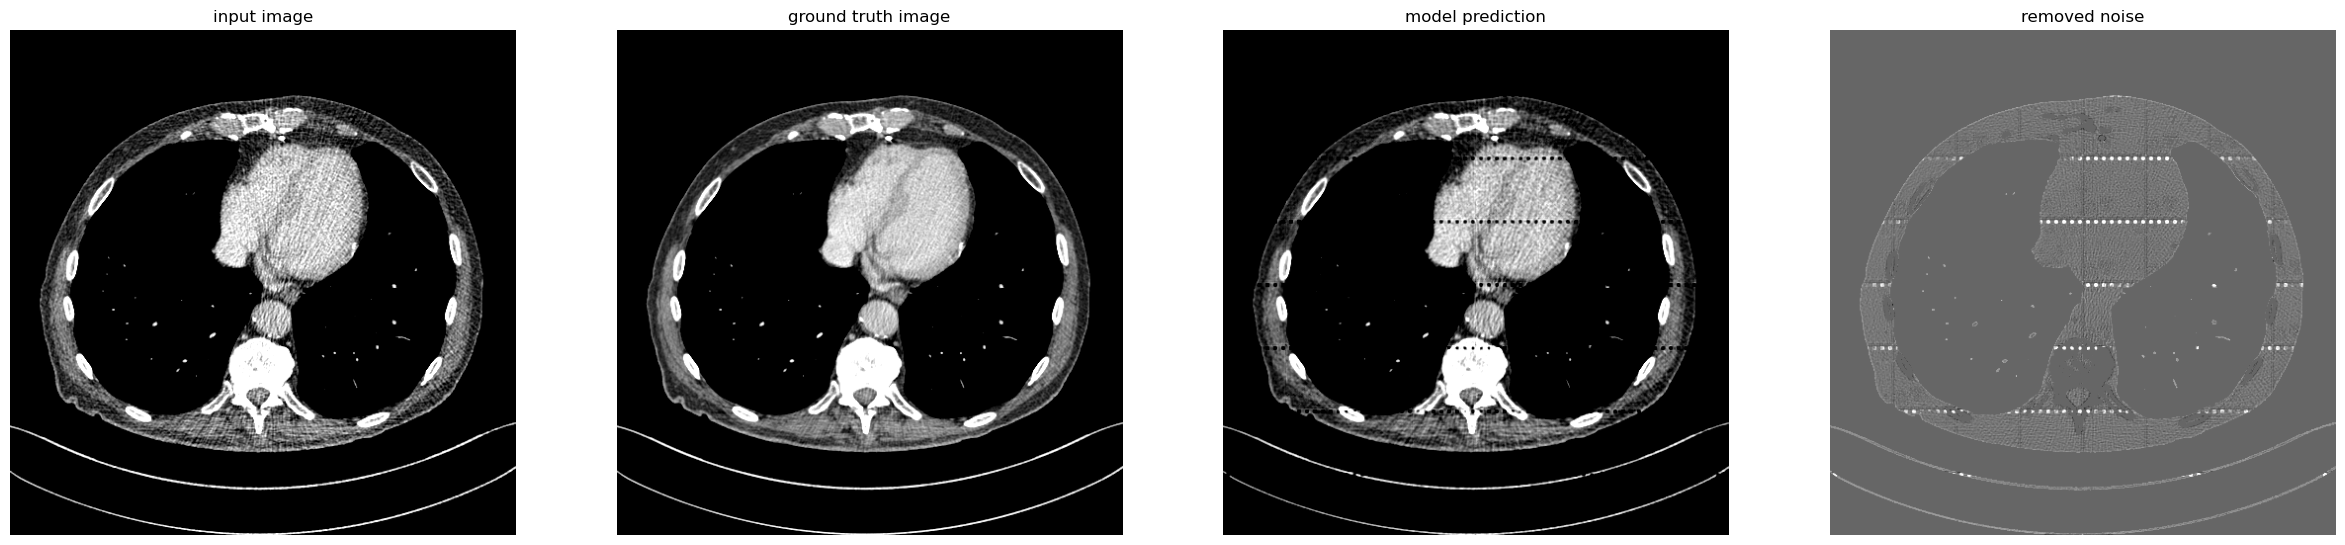

(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (64, 64, 1)
PSNR of reconsturcted image :  24.433215420256886
PSNR of noisy image :  27.320032737090333
SSIM of noisy image :  0.9098041
SSIM of reconstructed image :  0.87275606


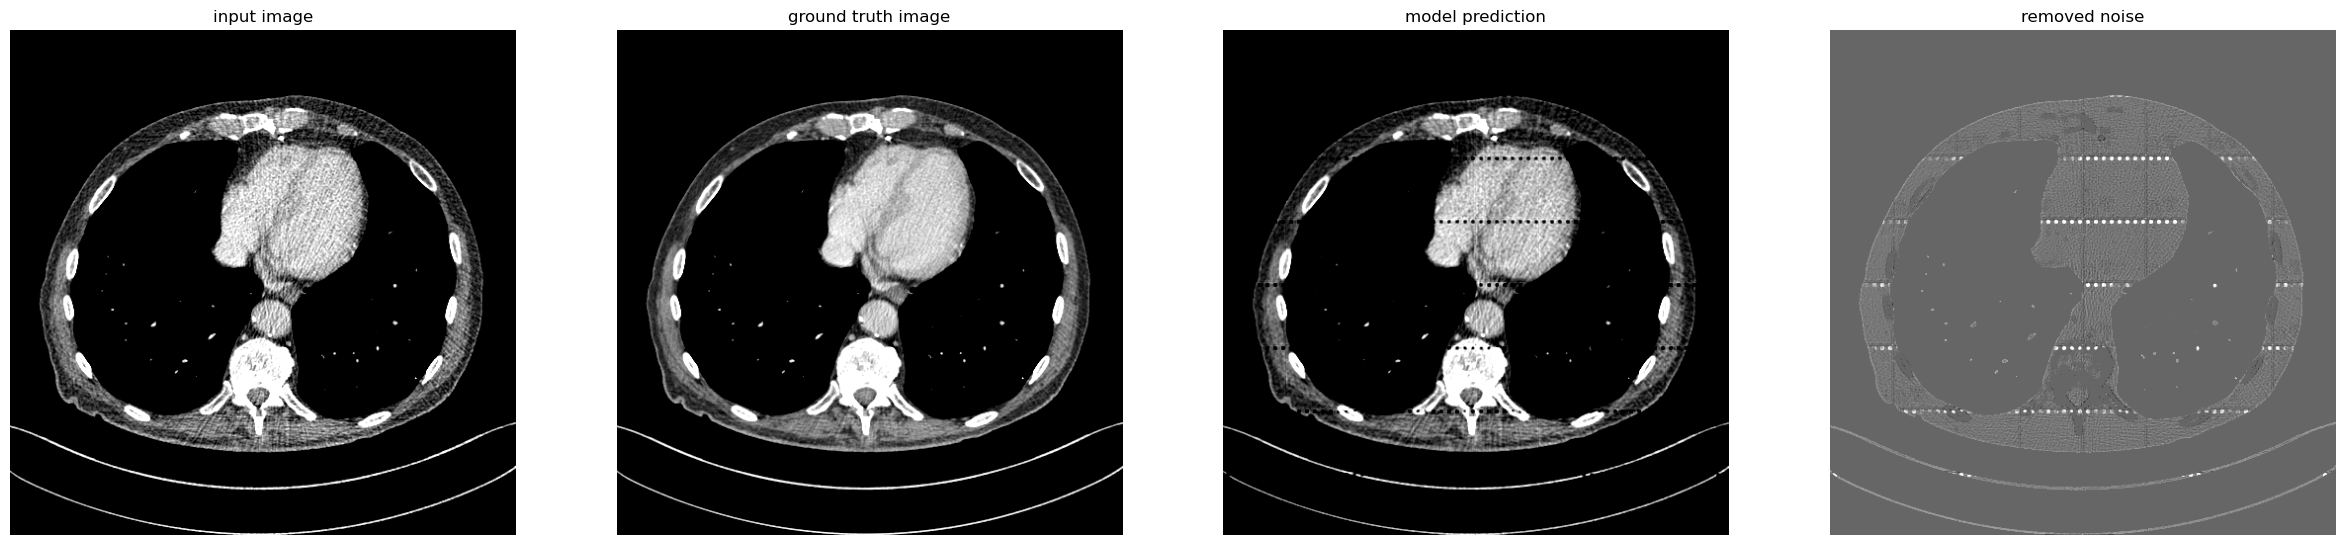

(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (64, 64, 1)
PSNR of reconsturcted image :  24.33724074205159
PSNR of noisy image :  27.166770804752613
SSIM of noisy image :  0.90943474
SSIM of reconstructed image :  0.8718634


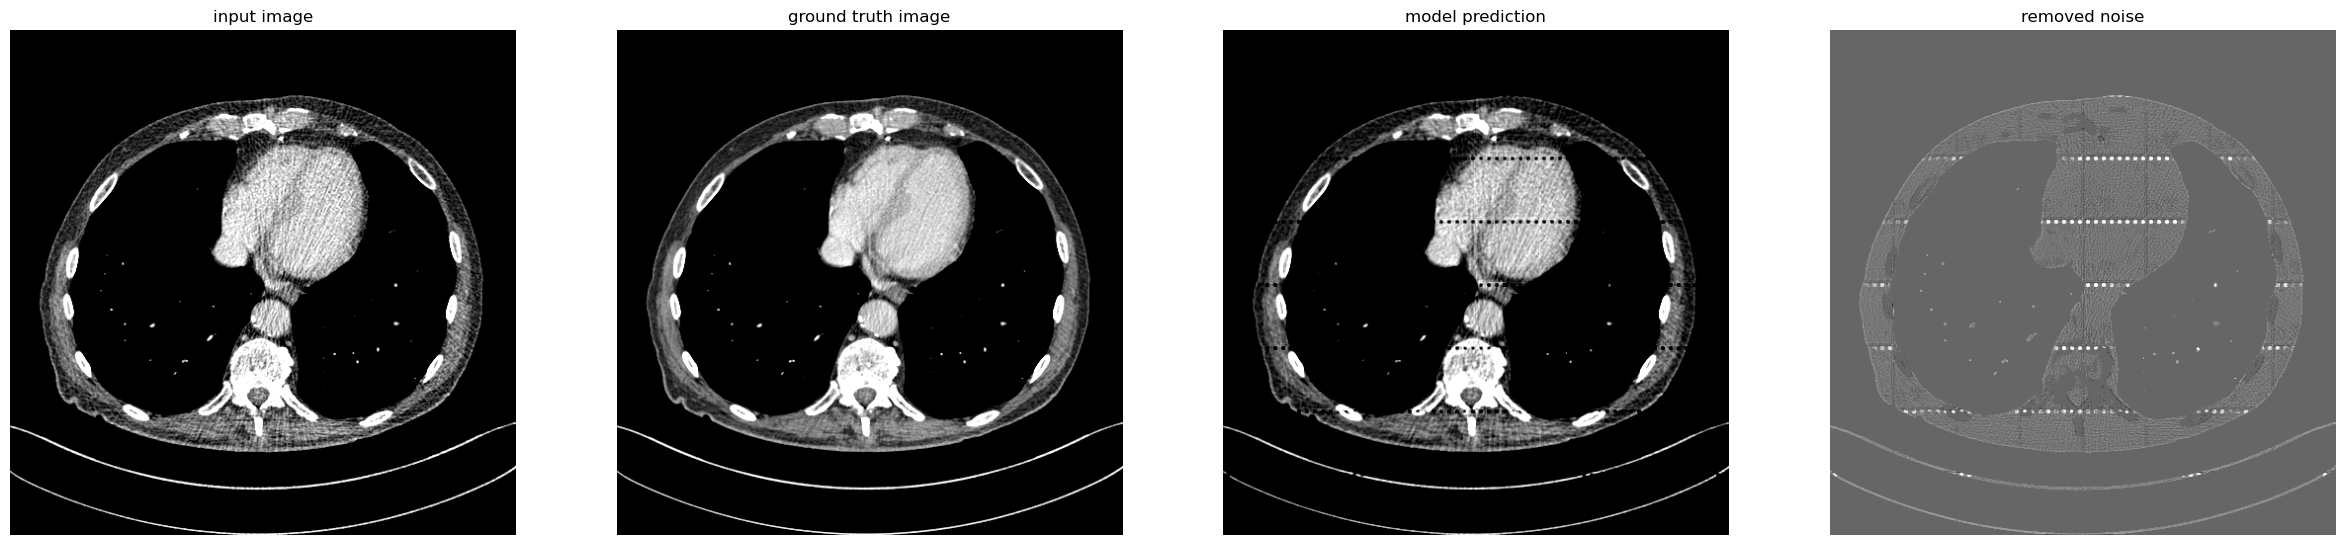

(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (64, 64, 1)
PSNR of reconsturcted image :  24.33462951450283
PSNR of noisy image :  27.148350107843694
SSIM of noisy image :  0.90980643
SSIM of reconstructed image :  0.8722768


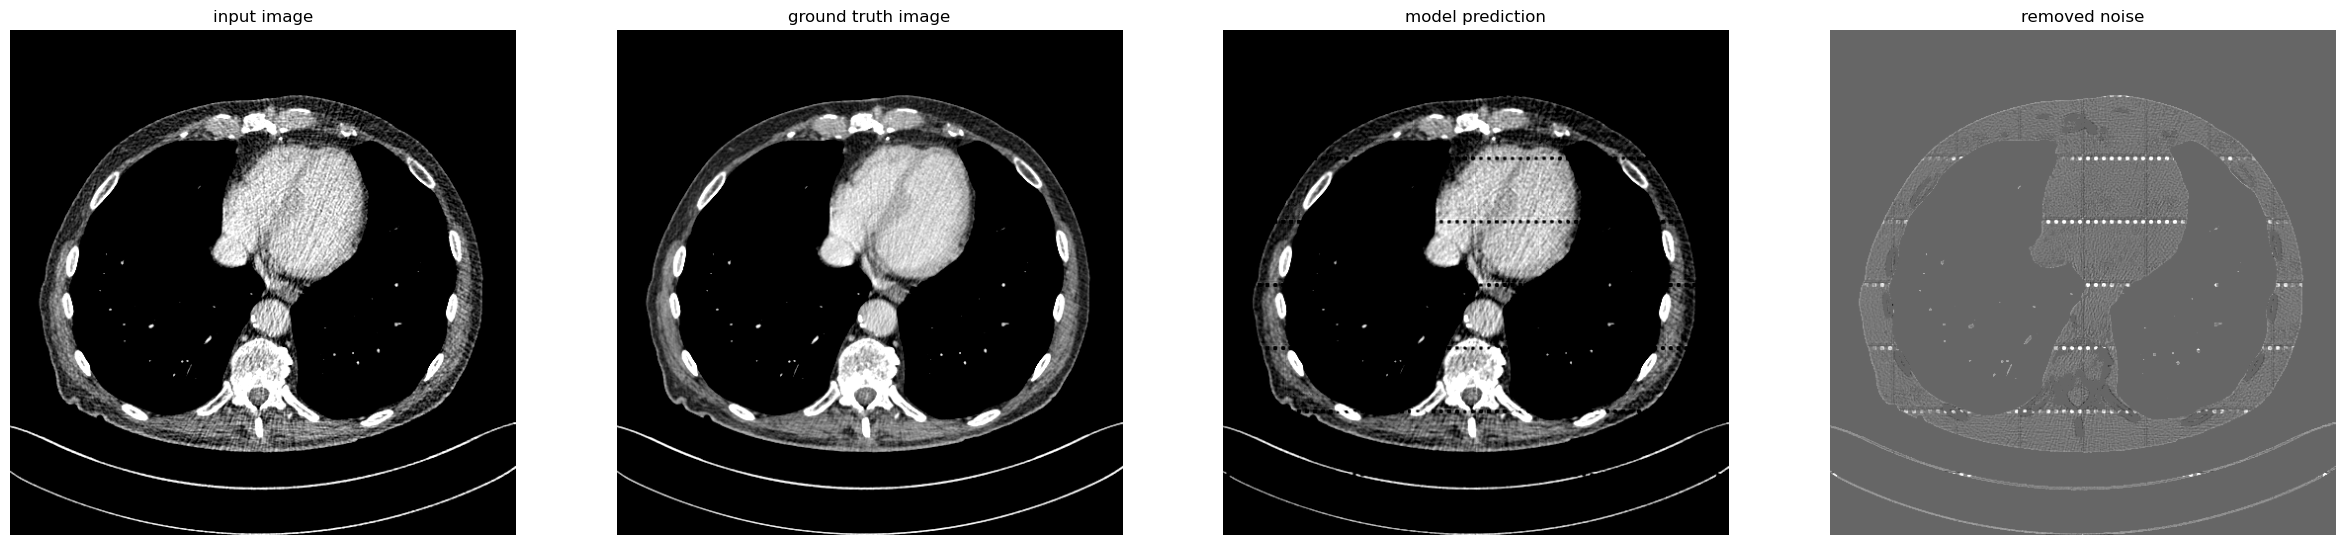

In [34]:
from hformer_model import HformerModel

model = HformerModel(num_channels=64).cuda()
model.load_state_dict(torch.load('weights/model_37.pth'))
model.eval()

evaluate_model(model, None, 'hformer_64_extended_partial_epoch', 'psnr')

# Test on hformer self attention

Training history of model :  hformer_64_extended_partial_epoch
Model prediction test
(256, 64, 64, 1)
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (64, 64, 1)
PSNR of reconsturcted image :  16.336805492779355
PSNR of noisy image :  26.821704742748672
SSIM of noisy image :  0.90582067
SSIM of reconstructed image :  0.7249131


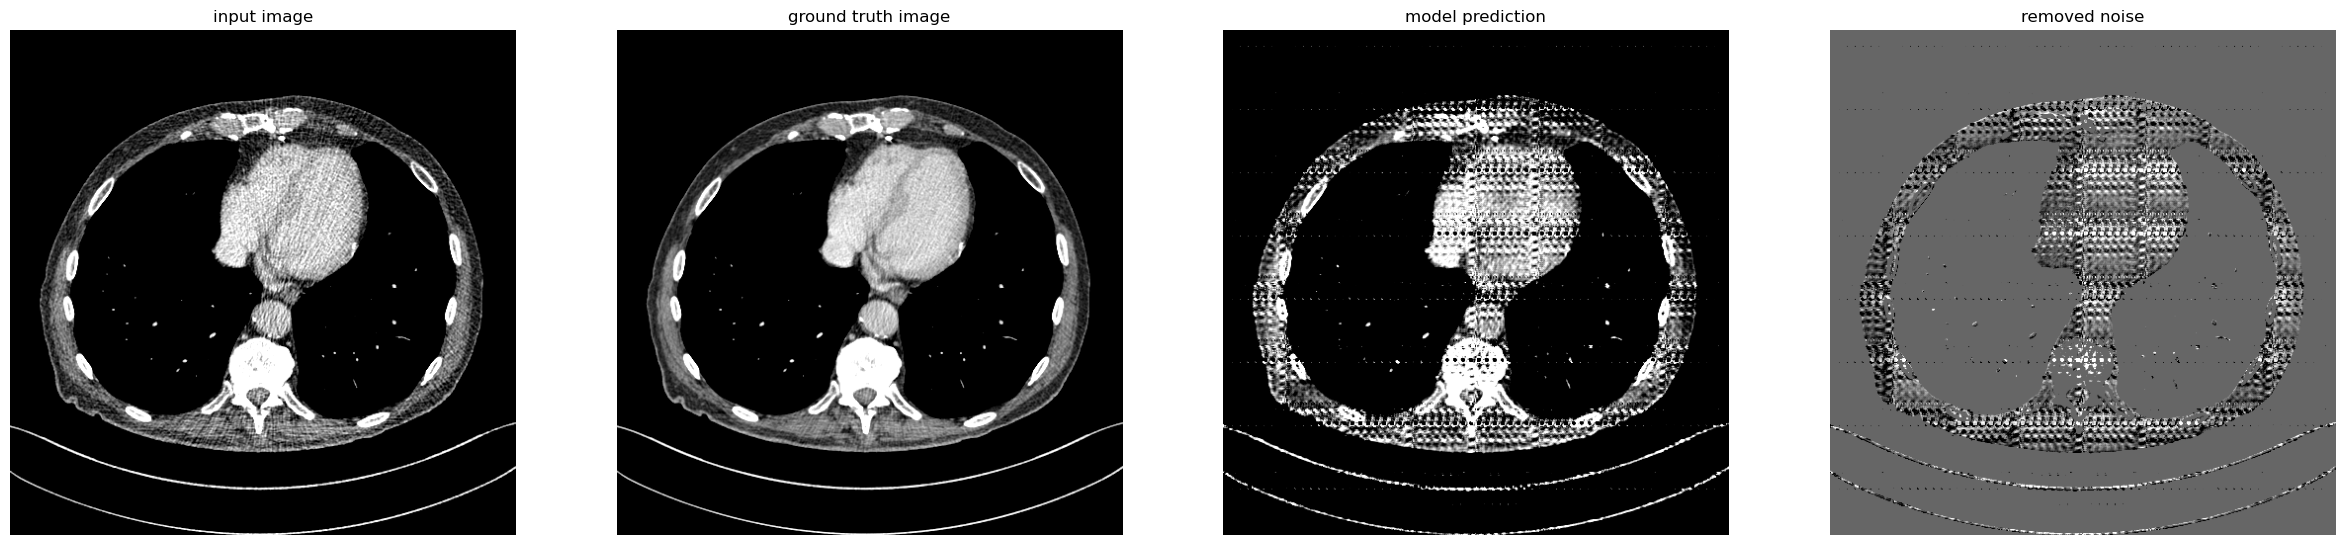

(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (64, 64, 1)
PSNR of reconsturcted image :  16.348615621287202
PSNR of noisy image :  27.320032737090333
SSIM of noisy image :  0.9098041
SSIM of reconstructed image :  0.72584283


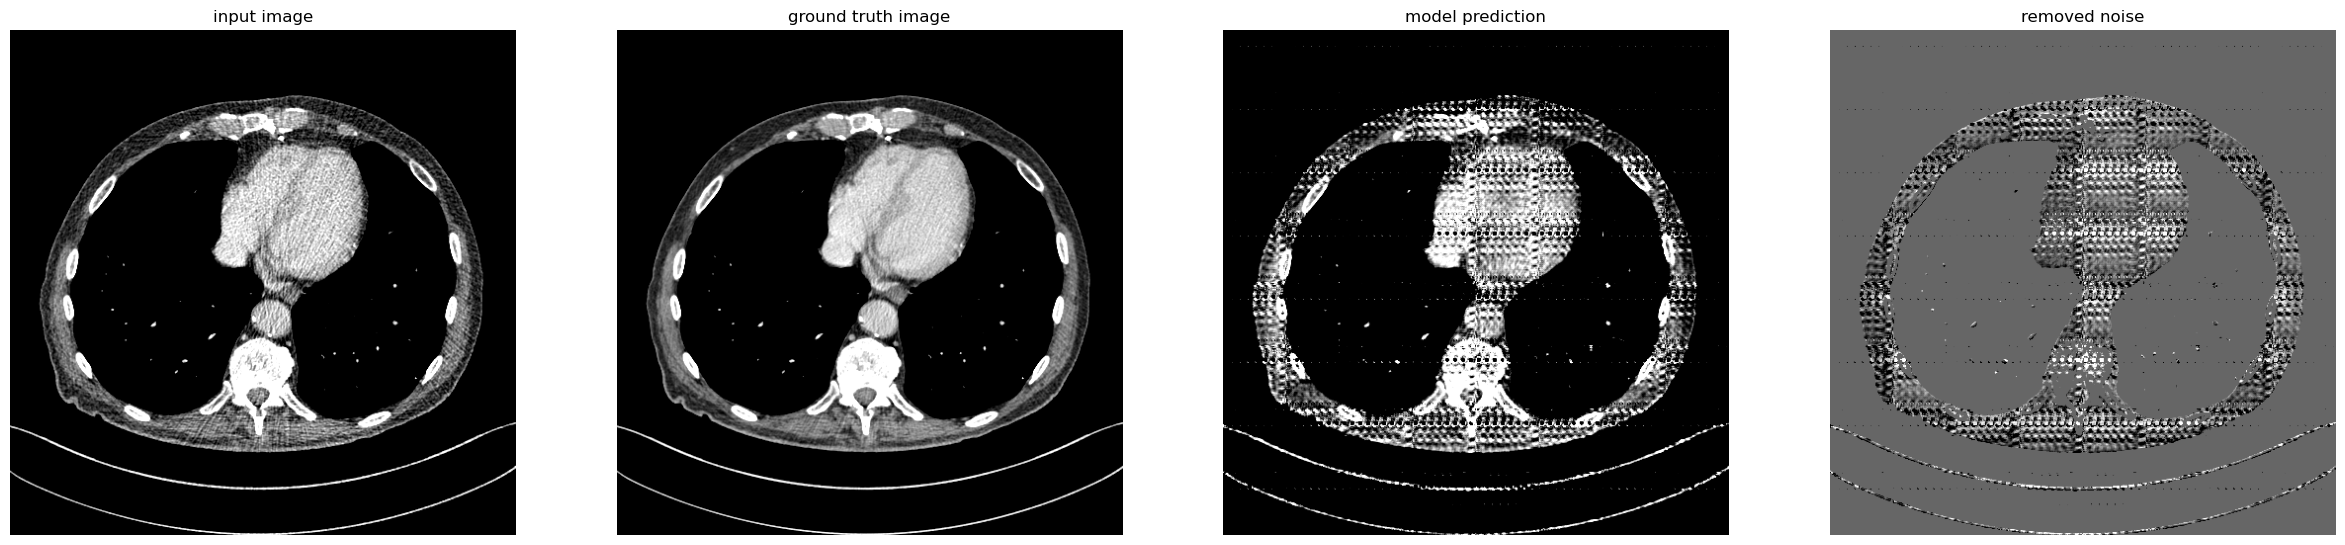

(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (64, 64, 1)
PSNR of reconsturcted image :  16.357381075356574
PSNR of noisy image :  27.166770804752613
SSIM of noisy image :  0.90943474
SSIM of reconstructed image :  0.7272546


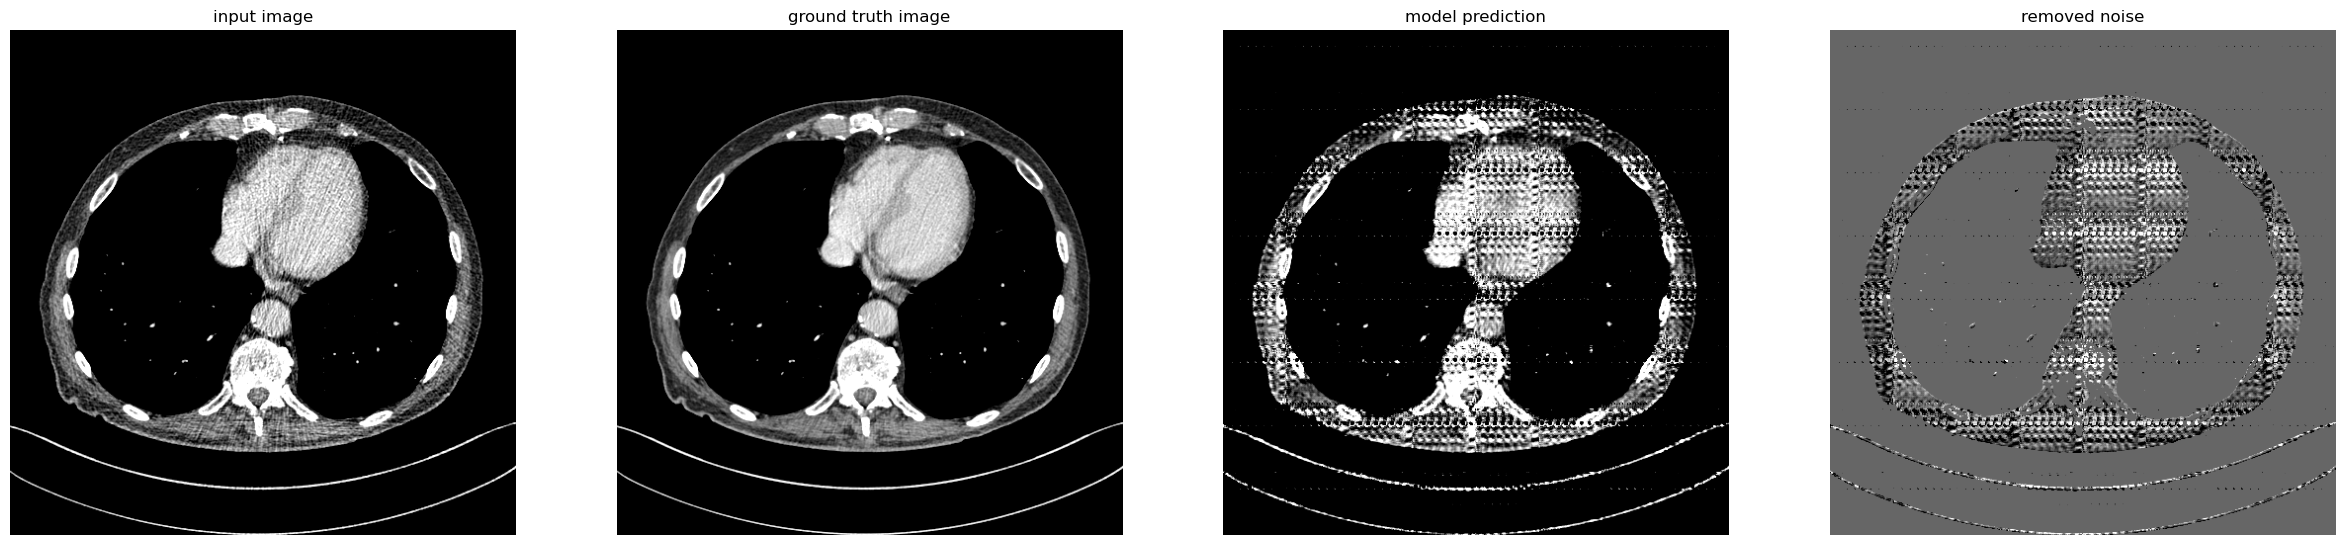

(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
(64, 64, 64, 1)  shape before reconstructing image from patches
range of reconstructed image :  -160.0 240.0
range of clean image :  -160.0 240.0
reconstruct_image shape :  (512, 512, 1)
noisy image shape :  (64, 64, 1)
PSNR of reconsturcted image :  16.354587447047862
PSNR of noisy image :  27.148350107843694
SSIM of noisy image :  0.90980643
SSIM of reconstructed image :  0.72676635


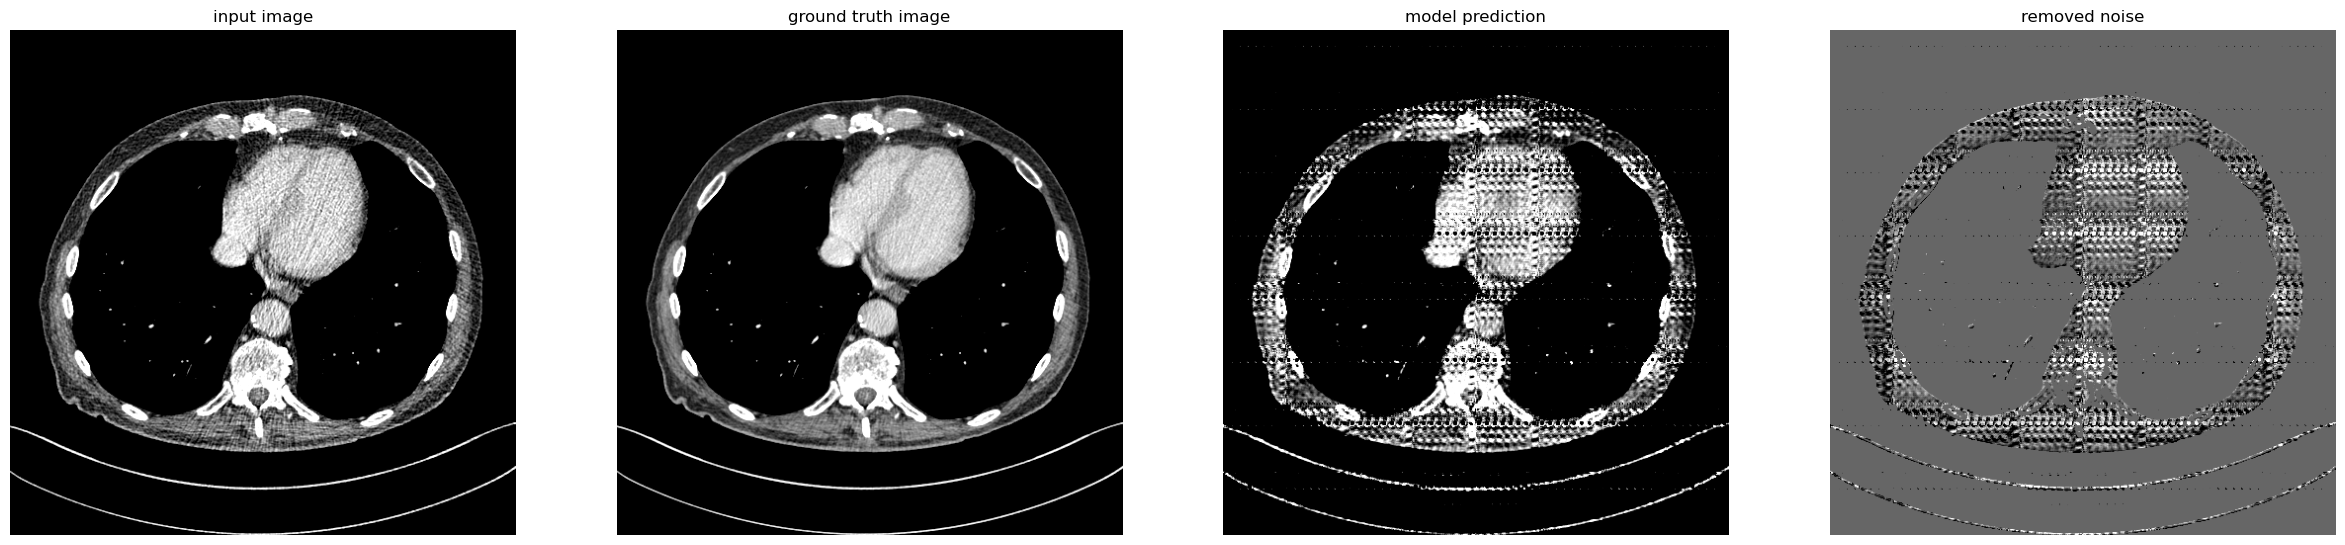

In [35]:
import sys
sys.path.append('../hformer_self_attention')


from hformer_sa_model import HformerSAModel 

model = HformerSAModel(num_channels=64).cuda()
model.load_state_dict(torch.load('../hformer_self_attention/weights/model_52.pth'))
model.eval()

evaluate_model(model, None, 'hformer_64_extended_partial_epoch', 'psnr')